In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import pickle
from scipy.interpolate import interp1d
import imageio.v2 as imageio
from pathlib import Path

from src.data.file_utils import GetTV


In [49]:
def nearest_index(array, value):
    """Find the index of the nearest value in an array."""
    return (np.abs(array - value)).argmin()

def crop_time(times, data, start_time, end_time):
    """Crop the data to the specified time range."""
    if data.ndim == 1:
        data = data.reshape(1, -1)
    start_idx = nearest_index(times, start_time)
    end_idx = nearest_index(times, end_time)
    return times[start_idx:end_idx], data[:,start_idx:end_idx]

In [50]:
tv = GetTV('../data/raw/tv_images/all')
files = tv.list_files()
for idx, file in enumerate(files):
    print(idx, '\t',file.stem.split('_')[-1])

0 	 189057
1 	 189061
2 	 189062
3 	 189081
4 	 189088
5 	 189090
6 	 189093
7 	 189094
8 	 189097
9 	 189100
10 	 189101
11 	 189448
12 	 189451
13 	 190109
14 	 190110
15 	 190113
16 	 190114
17 	 190115
18 	 190116
19 	 199166
20 	 199171
21 	 199172
22 	 199351
23 	 199352
24 	 199353
25 	 199354


In [53]:
file_idx = 25
print('Extracting sav for shot:', files[file_idx].stem.split('_')[-1])

[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = tv.load_all(files[file_idx])
inverted_times = vid_times[frames.astype(int)]
inverted_dim = inverted.shape
if (inverted_dim[1] != 201) or (inverted_dim[2] != 201):
    print('Resizing')
    inverted = inverted[:,:201,:201]
    radii = radii[:,:201]
    elevation = elevation[:,:201]

Extracting sav for shot: 199354
Resizing


In [55]:
print(radii.shape)
print(radii[0])

(119, 201)
[1.    1.005 1.01  1.015 1.02  1.025 1.03  1.035 1.04  1.045 1.05  1.055
 1.06  1.065 1.07  1.075 1.08  1.085 1.09  1.095 1.1   1.105 1.11  1.115
 1.12  1.125 1.13  1.135 1.14  1.145 1.15  1.155 1.16  1.165 1.17  1.175
 1.18  1.185 1.19  1.195 1.2   1.205 1.21  1.215 1.22  1.225 1.23  1.235
 1.24  1.245 1.25  1.255 1.26  1.265 1.27  1.275 1.28  1.285 1.29  1.295
 1.3   1.305 1.31  1.315 1.32  1.325 1.33  1.335 1.34  1.345 1.35  1.355
 1.36  1.365 1.37  1.375 1.38  1.385 1.39  1.395 1.4   1.405 1.41  1.415
 1.42  1.425 1.43  1.435 1.44  1.445 1.45  1.455 1.46  1.465 1.47  1.475
 1.48  1.485 1.49  1.495 1.5   1.505 1.51  1.515 1.52  1.525 1.53  1.535
 1.54  1.545 1.55  1.555 1.56  1.565 1.57  1.575 1.58  1.585 1.59  1.595
 1.6   1.605 1.61  1.615 1.62  1.625 1.63  1.635 1.64  1.645 1.65  1.655
 1.66  1.665 1.67  1.675 1.68  1.685 1.69  1.695 1.7   1.705 1.71  1.715
 1.72  1.725 1.73  1.735 1.74  1.745 1.75  1.755 1.76  1.765 1.77  1.775
 1.78  1.785 1.79  1.795 1.8   1.805 1.8

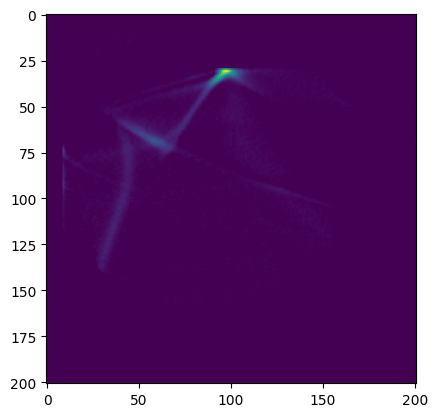

In [42]:
plt.imshow(inverted[0])

In [35]:
print(elevation)

[[-1.4   -1.395 -1.39  ... -0.01  -0.005  0.   ]
 [-1.4   -1.395 -1.39  ... -0.01  -0.005  0.   ]
 [-1.4   -1.395 -1.39  ... -0.01  -0.005  0.   ]
 ...
 [-1.4   -1.395 -1.39  ... -0.01  -0.005  0.   ]
 [-1.4   -1.395 -1.39  ... -0.01  -0.005  0.   ]
 [-1.4   -1.395 -1.39  ... -0.01  -0.005  0.   ]]


In [6]:
scaling_factor = 10
radii_hires = np.linspace(radii[0][0],radii[0][-1],len(radii[0])*scaling_factor)
elevation_hires = np.linspace(elevation[0][0],elevation[0][-1],len(elevation[0])*scaling_factor)

In [7]:
pkl_path = '../data/external/toksearch/detach.pkl'

with open(pkl_path, 'rb') as file:
    points = pickle.load(file)

point_keys = list(points.keys())
shot = points[point_keys[file_idx]]['vars']
times = points[point_keys[file_idx]]['time']
times_transp = np.transpose(times)
shot_transp = np.transpose(shot)
print("Extracting pkl for shot: ", point_keys[file_idx])

Extracting pkl for shot:  199166


In [8]:
crop_times, crop_shot = crop_time(times_transp, shot_transp, inverted_times[0], inverted_times[-1])
rx = crop_shot[0] / 1e2
zx = crop_shot[1] / 1e2
rs = crop_shot[2] / 1e2
zs = crop_shot[3] / 1e2

interp_kind = 'linear'
interpolator = interp1d(crop_times, rx, kind=interp_kind,
                        fill_value='extrapolate')
rx_interp = interpolator(inverted_times)
interpolator = interp1d(crop_times, zx, kind=interp_kind,
                        fill_value='extrapolate')
zx_interp = interpolator(inverted_times)
interpolator = interp1d(crop_times, rs, kind=interp_kind,
                        fill_value='extrapolate')
rs_interp = interpolator(inverted_times)
interpolator = interp1d(crop_times, zs, kind=interp_kind,
                        fill_value='extrapolate')
zs_interp = interpolator(inverted_times)

In [9]:
def get_index(arr, coord):
    # Get the insertion indices
    ind = np.searchsorted(coord, arr)

    # Correct the indices to point to the nearest actual index
    ind = np.clip(ind, 0, len(coord) - 1)

    # Now, adjust the indices to get the closest value
    for i, cval in enumerate(arr):
        if ind[i] > 0 and abs(cval - coord[ind[i] - 1]) < abs(cval - coord[ind[i]]):
            ind[i] -= 1
            
    return ind

In [10]:
rx_idx = get_index(rx_interp, radii_hires) / scaling_factor
zx_idx = get_index(zx_interp, elevation_hires) / scaling_factor
zs_idx = get_index(zs_interp, elevation_hires) / scaling_factor

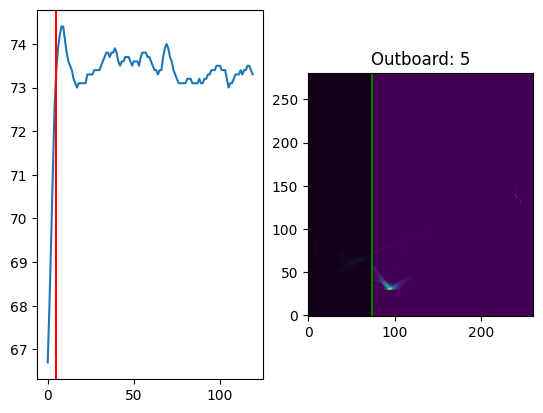

In [22]:
idx = 5
inverted_img = inverted[idx]
filter_img = (inverted_img > 0.1) * inverted_img
plt.subplot(1, 2, 1)
plt.plot(rx_idx)
plt.axvline(idx, color='r')
plt.subplot(1, 2, 2)
plt.imshow(filter_img, origin='lower')
plt.axvspan(0, rx_idx[idx], color='black', alpha=0.7)
plt.axvline(rx_idx[idx], color='g')
plt.title(f'Outboard: {idx}')
plt.show()

In [23]:
r = np.round(rx_idx[idx]).astype(int)
sum_outer = np.sum(filter_img[:,r:],axis=1)

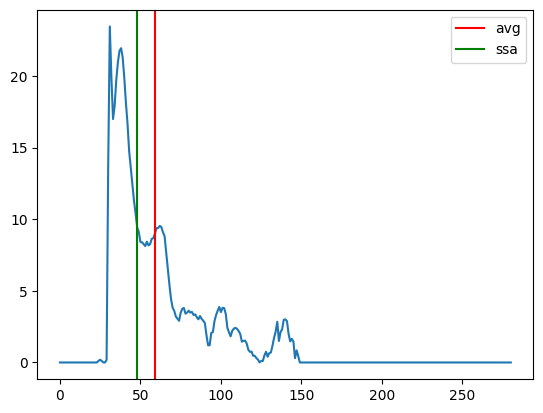

In [13]:
indicies = np.arange(0, filter_img.shape[0])
weighted_sum = np.sum(indicies * sum_outer)
weighted_squre_sum = np.sum((indicies * sum_outer)**2)
total_weight = np.sum(sum_outer)
total_square_weight = np.sum(sum_outer**2)
avg = weighted_sum / total_weight
sqrt_sum_sq_avg = (weighted_squre_sum / total_square_weight)**0.5
plt.plot(sum_outer)
plt.axvline(avg,c='r', label='avg')
plt.axvline(sqrt_sum_sq_avg,c='g', label='ssa')
plt.legend()
plt.show()

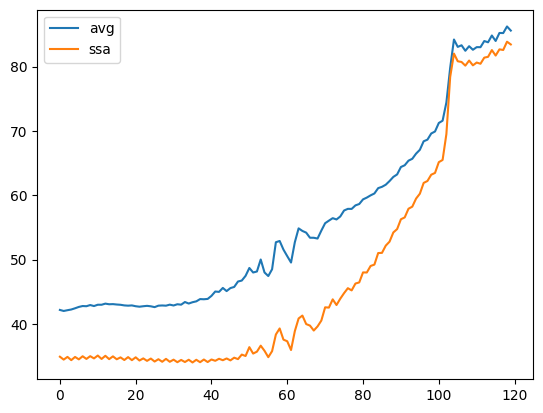

In [14]:
z_arr_avg = []
z_arr_ssa = []
for idx, inverted_img in enumerate(inverted):
    filter_img = (inverted_img > 0.1) * inverted_img
    r = np.round(rx_idx[idx]).astype(int)
    sum_outer = np.sum(filter_img[:,r:],axis=1)
    indicies = np.arange(0, filter_img.shape[0])
    
    weighted_sum = np.sum(indicies * sum_outer)
    avg = weighted_sum / np.sum(sum_outer)
    z_arr_avg.append(avg)
    
    weighted_square_sum = np.sum((indicies * sum_outer)**2)
    total_square_weight = np.sum(sum_outer**2)
    sqrt_sum_sq_avg = (weighted_square_sum / total_square_weight)**0.5
    z_arr_ssa.append(sqrt_sum_sq_avg)
plt.plot(z_arr_avg, label='avg')
plt.plot(z_arr_ssa, label='ssa')
plt.legend()
plt.show()

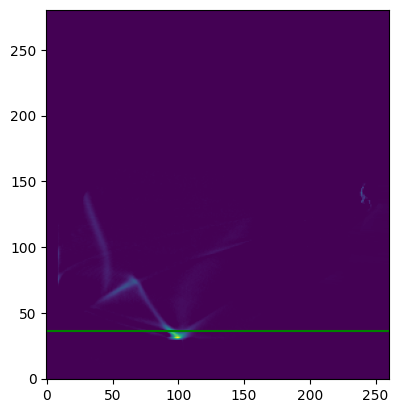

In [15]:
idx = 50
plt.imshow(inverted[idx], origin='lower')
plt.axhline(z_arr_ssa[idx],c='g')
plt.show()

In [18]:
print(inverted.shape)

(120, 281, 261)


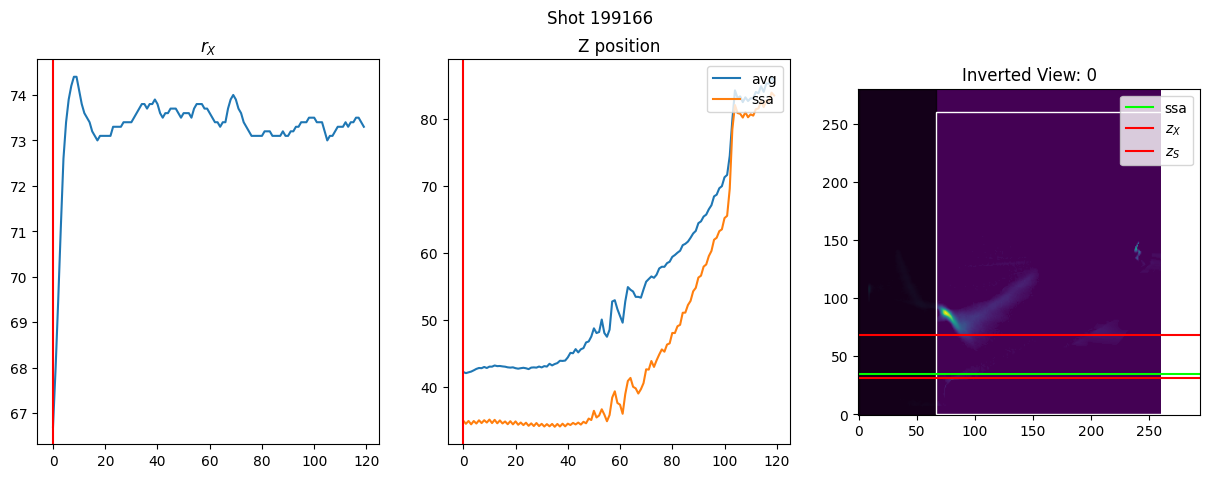

In [16]:
shot_length = inverted_dim[0]
idx = 0

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

rect = patches.Rectangle((rx_idx[idx], 0), inverted_dim[1]-rx_idx[idx]-1, inverted_dim[2]-1, linewidth=1, edgecolor='w', facecolor='none')

ax_idx = 0
ax[ax_idx].plot(rx_idx)
ax[ax_idx].axvline(idx, color='r')
ax[ax_idx].set_title('$r_X$')

ax_idx = 1
ax[ax_idx].plot(z_arr_avg, label='avg')
ax[ax_idx].plot(z_arr_ssa, label='ssa')
ax[ax_idx].axvline(idx, color='r')
ax[ax_idx].legend(loc='upper right')
ax[ax_idx].set_title('Z position')

ax_idx = 2
ax[ax_idx].imshow(filter_img, origin='lower')
ax[ax_idx].axvspan(0, rx_idx[idx], color='black', alpha=0.7)
ax[ax_idx].set_title(f'Inverted View: {idx}')
ax[ax_idx].add_patch(rect)
ax[ax_idx].axhline(z_arr_ssa[idx],c='lime', label='ssa')
ax[ax_idx].axhline(zx_idx[idx],c='r', label='$z_X$')
ax[ax_idx].axhline(zs_idx[idx],c='r', label='$z_S$')
ax[ax_idx].legend(loc='upper right')

fig.suptitle(f"Shot {files[file_idx].stem.split('_')[-1]}")

fig.show()

In [367]:
z_avg_rounds = [z*scaling_factor for z in z_arr_avg]
z_ssa_rounds = [z*scaling_factor for z in z_arr_ssa]

z_avg_real = elevation_hires[np.round(z_avg_rounds).astype(int)]
z_ssa_real = elevation_hires[np.round(z_ssa_rounds).astype(int)]

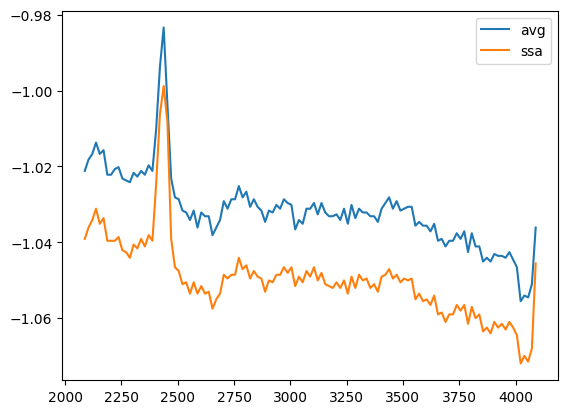

In [368]:
plt.plot(inverted_times,z_avg_real, label='avg')
plt.plot(inverted_times,z_ssa_real, label='ssa')
plt.legend()
plt.show()

In [ ]:
in_path = Path(in_path)
out_path = Path(out_path)
out_path.mkdir(parents=True, exist_ok=True)

for file in files:
    
# Initialize figure and axes
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Initial plots
line_rx, = ax[0].plot(rx_idx)
vline_rx = ax[0].axvline(0, color='r')
ax[0].set_title('$r_X$')

line_avg, = ax[1].plot(z_arr_avg, label='avg')
line_ssa, = ax[1].plot(z_arr_ssa, label='ssa')
vline_z = ax[1].axvline(0, color='r')
ax[1].legend(loc='upper right')
ax[1].set_title('Z position')

img = ax[2].imshow(filter_img, origin='lower')
rect = patches.Rectangle((rx_idx[0], 0), inverted_dim[1]-rx_idx[0]-1, inverted_dim[2]-1, linewidth=1, edgecolor='w', facecolor='none')
ax[2].add_patch(rect)
vspan = ax[2].axvspan(0, rx_idx[0], color='black', alpha=0.7)
hline_ssa = ax[2].axhline(z_arr_ssa[0], c='lime', label='ssa')
hline_zx = ax[2].axhline(zx_idx[0], c='r', label='$z_X$')
hline_zs = ax[2].axhline(zs_idx[0], c='r', label='$z_S$')
ax[2].legend(loc='upper right')
ax[2].set_title(f'Inverted View: 0')

fig.suptitle(f"Shot {0}")

# Function to update the plot
def update(idx):
    vline_rx.set_xdata(idx)
    vline_z.set_xdata(idx)
    
    rect.set_x(rx_idx[idx])
    vspan.set_xy((0, 0))  # Reset the x position of the span
    vspan.set_width(rx_idx[idx])
    
    hline_ssa.set_ydata(z_arr_ssa[idx])
    hline_zx.set_ydata(zx_idx[idx])
    hline_zs.set_ydata(zs_idx[idx])
    
    ax[2].set_title(f'Inverted View: {idx}')
    fig.suptitle(f"Shot {idx}")
    
    return vline_rx, vline_z, rect, vspan, hline_ssa, hline_zx, hline_zs

# Create a list to store frames for GIF
frames = []

# Generate frames for both GIF and MP4
for idx in range(inverted_dim[0]):
    update(idx)
    fig.canvas.draw()  # Render the plot
    
    # Convert the plot to a numpy array and append it to the frames list
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)

# Save the frames as a GIF using imageio
imageio.mimsave('animation.gif', frames, fps=10)

# Create an MP4 animation using matplotlib's animation functionality
ani = animation.ArtistAnimation(fig, [[ax[2]] for _ in range(inverted_dim[0])], blit=True, repeat=False)

# Save the animation as MP4 using ffmpeg
ani.save('animation.mp4', writer='ffmpeg', fps=10)

plt.close(fig)